In [1]:
import numpy as np
import torch

In [2]:
from utils import vector_padding, extract_entity_relation_pair

### 读取数据

In [3]:
triple_vecs = np.load('./train_triple_vecs.npy', allow_pickle=True)
print(triple_vecs.shape)

(14600,)


In [4]:
question_vecs = np.load('./train_question_vecs.npy', allow_pickle=True)
print(question_vecs.shape)

(14600,)


### 预处理

In [5]:
pvecs = extract_entity_relation_pair(triple_vecs)

extracting pairs 14600/14600...Done!


In [6]:
qvecs = vector_padding(question_vecs)

padding vectors  14600/14600...Done!


### 模型定义

In [7]:
from models.dual_learn import DualTaskQAGSystem

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
net = DualTaskQAGSystem(max_len=qvecs.shape[1], pair_len=pvecs.shape[1], feat_dim=qvecs.shape[-1], max_iter=40,
                        QA_d_model=256, QA_n_heads=8, QA_num_layers=3, QA_dim_feedforward=512, QA_dropout=0.1, QA_act='gelu', 
                        QA_epochs=5, QA_lr=1e-5, QA_weight_l2=1e-12,
                        QG_d_model=128, QG_n_heads=16, QG_num_layers=3, QG_dim_feedforward=256, QG_dropout=0.1, QG_act='gelu', 
                        QG_epochs=5, QG_lr=1e-5, QG_weight_l2=1e-12,
                        batch_size=1024, device=device)

In [10]:
net.preprocess_data(qvecs, pvecs)

Question vectors shape: torch.Size([14600, 26, 300])
Entity-Relation pairs shape: torch.Size([14600, 2, 300])
Step:0  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:1  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:2  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:3  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:4  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:5  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:6  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:7  question vectors shape: torch.Size([1024, 26, 300]) , pair vectors shape: torch.Size([1024, 2, 300])
Step:8  question v

(<torch.utils.data.dataloader.DataLoader at 0x7fe480862dd8>, 15)

### 加载训练好的模型（如果有的话）

In [11]:
#net = torch.load("./checkpoints/best_QG.net")

### 训练

In [12]:
loss_QA, loss_QG_en, loss_QG_re = net.train()

--------------- Iteration 1 ---------------
-- trainning QA model --
epoch=1, loss=0.189807, time=2.78s per epoch
epoch=2, loss=0.164956, time=2.79s per epoch
epoch=3, loss=0.153148, time=2.75s per epoch
epoch=4, loss=0.146227, time=2.76s per epoch
epoch=5, loss=0.141807, time=2.83s per epoch
-- trainning QG model --
epoch=1, loss=0.627353, time=2.81s per epoch
epoch=2, loss=0.543759, time=2.82s per epoch
epoch=3, loss=0.486872, time=2.86s per epoch
epoch=4, loss=0.453294, time=2.84s per epoch
epoch=5, loss=0.436688, time=2.84s per epoch
--------------- Iteration 2 ---------------
-- trainning QA model --
epoch=1, loss=0.139047, time=2.81s per epoch
epoch=2, loss=0.134933, time=2.64s per epoch
epoch=3, loss=0.132388, time=2.83s per epoch
epoch=4, loss=0.130681, time=2.79s per epoch
epoch=5, loss=0.129158, time=2.79s per epoch
-- trainning QG model --
epoch=1, loss=0.454965, time=2.84s per epoch
epoch=2, loss=0.439791, time=2.79s per epoch
epoch=3, loss=0.427625, time=2.82s per epoch
ep

In [13]:
np.save("loss_QA.npy", loss_QA)
np.save("loss_QG_en.npy", loss_QG_en)
np.save("loss_QG_re.npy", loss_QG_re)

In [62]:
torch.save(net, "./checkpoints/dual_net_50_iters.pkt")

### 可视化

In [14]:
import matplotlib.pyplot as plt

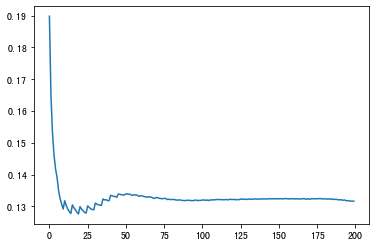

In [15]:
plt.plot(loss_QA)

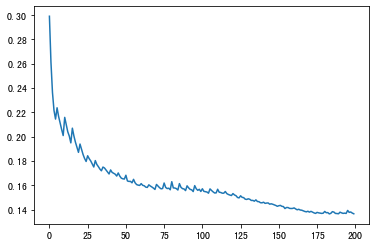

In [16]:
plt.plot(loss_QG_en)

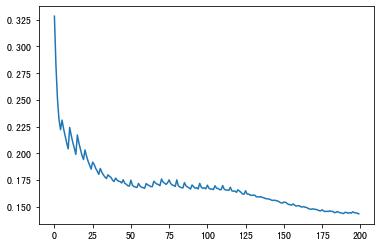

In [17]:
plt.plot(loss_QG_re)

In [23]:
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

In [36]:
y_loss = loss_QA + loss_QG_en + loss_QG_re
x_epoch = list(np.arange(1, len(loss_QA) + 1, 1)) * 3
hue = ["loss_QA"] * len(loss_QA) + ["loss_QG_en"] * len(loss_QG_en) + ["loss_QG_re"] * len(loss_QG_re)
df = pd.DataFrame({"Epoch": x_epoch,
                   "Loss": y_loss,
                   "Model": hue})

In [34]:
df

,Epoch,Loss,hue
0,1,0.189807,loss_QA
1,2,0.164956,loss_QA
2,3,0.153148,loss_QA
3,4,0.146227,loss_QA
4,5,0.141807,loss_QA
...,...,...,...
595,196,0.145354,loss_QG_re
596,197,0.144639,loss_QG_re
597,198,0.144322,loss_QG_re
598,199,0.144232,loss_QG_re


[]

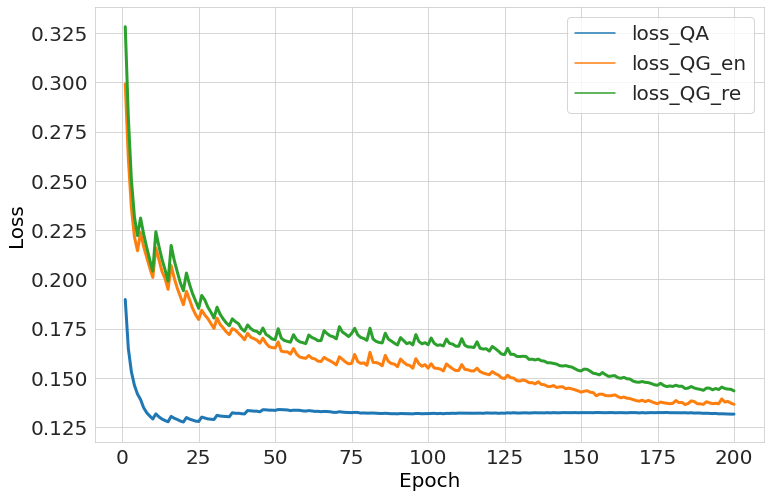

In [61]:
fontsize=20
labelcolor="black"

plt.figure(figsize=(12, 8))
sns.lineplot(x="Epoch", y="Loss", hue="Model", data=df, linewidth=3)

plt.xlabel("Epoch", fontsize=fontsize, color=labelcolor)
plt.ylabel("Loss", fontsize=fontsize, color=labelcolor)
plt.xticks(size=fontsize)
plt.yticks(size=fontsize)
plt.legend(prop={'size': fontsize})

plt.savefig("loss.pdf", dpi=1200)
plt.plot()

### 获取输出向量示例

In [18]:
question = qvecs[100:101, :] # 取一例 注意维度必须为3维
print(question.shape)

torch.Size([1, 26, 300])


In [19]:
ans_entity, ans_relation = net.predict_answer(question) # 输出实体与关系的embedding
print(ans_entity.shape, ans_relation.shape)

torch.Size([1, 300]) torch.Size([1, 300])


In [20]:
pair = pvecs[50:51, :] # 同样地，必须为三维
pair = torch.tensor(pair, dtype=torch.float32)
print(pair.shape)

torch.Size([1, 2, 300])


In [21]:
gen_question = net.generate_question(pair)
print(gen_question.shape)

torch.Size([1, 26, 300])
